<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/DIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt



In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [5]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), 
            nn.ReLU(True),
            nn.Linear(12, 2))

    def forward(self, x):
       
        x = self.encoder(x)
     
        
        return x

In [6]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc1 = nn.Linear(self.input_dim, self.base_size)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, self.input_size* self.input_size )
        initialize_weights(self)                    
    
    # forward method
    def forward(self, x): 
       
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
       
        return torch.tanh(self.fc4(x))



class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size



        self.fc1 = nn.Linear( self.input_size* self.input_size,self.base_size)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, output_dim)

        initialize_weights(self)

     # forward method
  def forward(self, x):
       # x = x.view(-1, self.input_size * self.input_size)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
       # x = x.view(-1, self.input_size * self.input_size)
      
        return torch.sigmoid(self.fc4(x))

In [24]:

def visualize_results(gan,recon_images):
      samples = recon_images.cpu().data.numpy().reshape(128,1,28,28)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
        s=ax[i].imshow(np.squeeze(samples[i,]))
        s=ax[i].get_xaxis().set_visible(False)
        s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [25]:

class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = params['base_size']
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        #print(data.shape[0])

        # initialization of the generator and discriminator
        
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[0], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[0], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
        # initialization of the loss function
        #self.BCE_loss = nn.SmoothL1Loss(beta=0.9)
        self.BCE_loss = nn.BCELoss().cuda()
        self.BCE_loss = nn.MSELoss()
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):

       # Setting empty arrays for storing the losses

        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        # Epoch loops

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                # Generate random noise to push through the generator   

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_, z_.cuda()
                
                x_ = Variable(x_).cuda(device).type(torch.cuda.FloatTensor)
                x_= x_.view(x_.size(0), -1)
                

               

                # update D network using 
                # 1. Set optimizer gradient to zero
                gan.D_optimizer.zero_grad()
                
                # 2. Set discriminator losses on real and fake data

                # training the encoder 
                encoder = autoencoder().cuda()

                # encoder is used for latent_variable mapping c
                recon =  encoder(x_)


                recon_real = gan.G(recon)
                recon_fake = gan.G(z_)


                #print(recon_fake.shape)
                D_real = gan.D(recon_real)
                #print(D_real.shape)

                
                D_real_loss = gan.BCE_loss(D_real,gan.y_real_)
                
                D_fake = gan.D(recon_fake)
                D_fake_loss = gan.BCE_loss(D_fake, gan.y_fake_)

                D_loss = D_real_loss + D_fake_loss





                # 3. Do back propagation to compute gradients
                D_loss.backward()
                # 4. Make a step of D_optimizer
                gan.D_optimizer.step()

                # 5. Set the current loss in self.train_hist['D_loss]
                gan.train_hist['D_loss'].append(D_loss.item())
                
                # update G network using 
                # 1. Set optimizer gradient to zero
                gan.G_optimizer.zero_grad()
                # 2. Set generator losses on fake data
               
                recon_fake = gan.G(z_)
                D_fake = gan.D(recon_fake)
                G_loss = gan.BCE_loss(D_fake, gan.y_real_)
                # 3. Do back propagation to compute gradients
                G_loss.backward()
                # 4. Make a step of G_optimizer
                gan.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                gan.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
    
                  
            # Visualize results
                with torch.no_grad():
                 visualize_results(self,recon_images=recon_real)
        #plt.figure(figsize=(16,8))
       # s=plt.plot(gan.train_hist['D_loss'],c='b')
        #s=plt.plot(gan.train_hist['G_loss'],c='r')
        #s = plt.ylim((0,1))
        #s = plt.grid()
       # s=plt.legend(('Discriminator loss','Generator loss'))

        print("Training finished!")

training start!!


<Figure size 72x720 with 0 Axes>

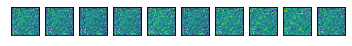

<Figure size 72x720 with 0 Axes>

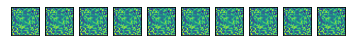

<Figure size 72x720 with 0 Axes>

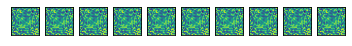

<Figure size 72x720 with 0 Axes>

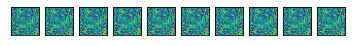

<Figure size 72x720 with 0 Axes>

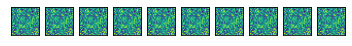

<Figure size 72x720 with 0 Axes>

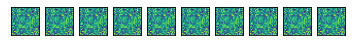

<Figure size 72x720 with 0 Axes>

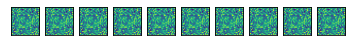

<Figure size 72x720 with 0 Axes>

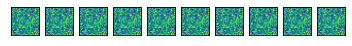

<Figure size 72x720 with 0 Axes>

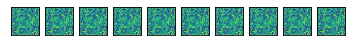

<Figure size 72x720 with 0 Axes>

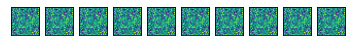

<Figure size 72x720 with 0 Axes>

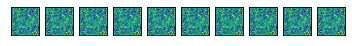

<Figure size 72x720 with 0 Axes>

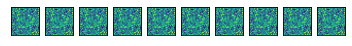

<Figure size 72x720 with 0 Axes>

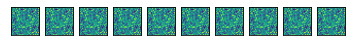

<Figure size 72x720 with 0 Axes>

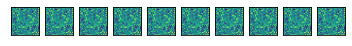

<Figure size 72x720 with 0 Axes>

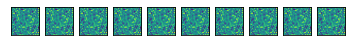

<Figure size 72x720 with 0 Axes>

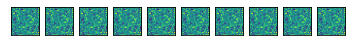

<Figure size 72x720 with 0 Axes>

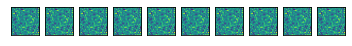

<Figure size 72x720 with 0 Axes>

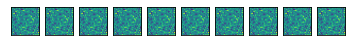

<Figure size 72x720 with 0 Axes>

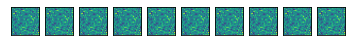

<Figure size 72x720 with 0 Axes>

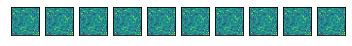

<Figure size 72x720 with 0 Axes>

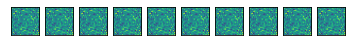

<Figure size 72x720 with 0 Axes>

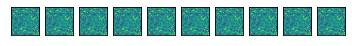

<Figure size 72x720 with 0 Axes>

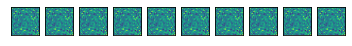

<Figure size 72x720 with 0 Axes>

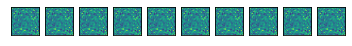

<Figure size 72x720 with 0 Axes>

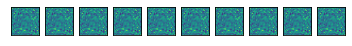

<Figure size 72x720 with 0 Axes>

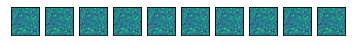

<Figure size 72x720 with 0 Axes>

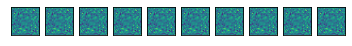

<Figure size 72x720 with 0 Axes>

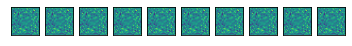

<Figure size 72x720 with 0 Axes>

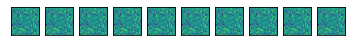

<Figure size 72x720 with 0 Axes>

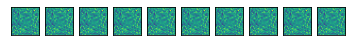

<Figure size 72x720 with 0 Axes>

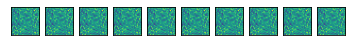

<Figure size 72x720 with 0 Axes>

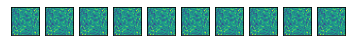

<Figure size 72x720 with 0 Axes>

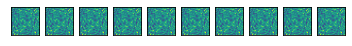

<Figure size 72x720 with 0 Axes>

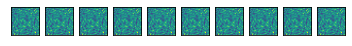

<Figure size 72x720 with 0 Axes>

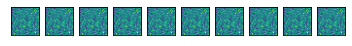

<Figure size 72x720 with 0 Axes>

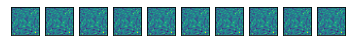

<Figure size 72x720 with 0 Axes>

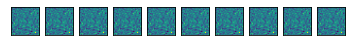

<Figure size 72x720 with 0 Axes>

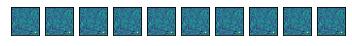

<Figure size 72x720 with 0 Axes>

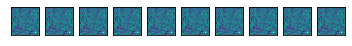

<Figure size 72x720 with 0 Axes>

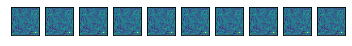

<Figure size 72x720 with 0 Axes>

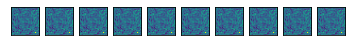

<Figure size 72x720 with 0 Axes>

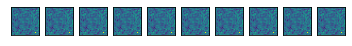

<Figure size 72x720 with 0 Axes>

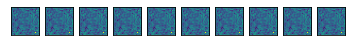

<Figure size 72x720 with 0 Axes>

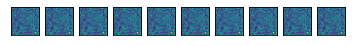

<Figure size 72x720 with 0 Axes>

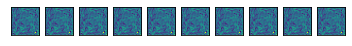

<Figure size 72x720 with 0 Axes>

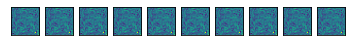

<Figure size 72x720 with 0 Axes>

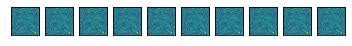

<Figure size 72x720 with 0 Axes>

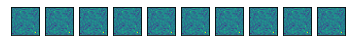

<Figure size 72x720 with 0 Axes>

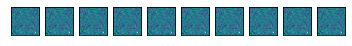

Epoch: [ 1] [  50/ 468] D_loss: 0.40884787, G_loss: 0.16510592


<Figure size 72x720 with 0 Axes>

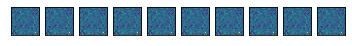

<Figure size 72x720 with 0 Axes>

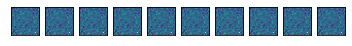

<Figure size 72x720 with 0 Axes>

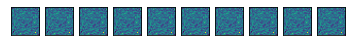

<Figure size 72x720 with 0 Axes>

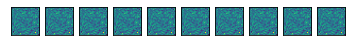

<Figure size 72x720 with 0 Axes>

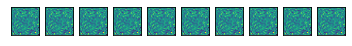

<Figure size 72x720 with 0 Axes>

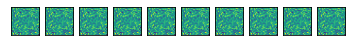

<Figure size 72x720 with 0 Axes>

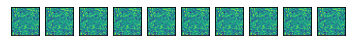

<Figure size 72x720 with 0 Axes>

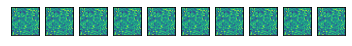

<Figure size 72x720 with 0 Axes>

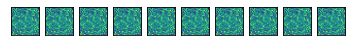

<Figure size 72x720 with 0 Axes>

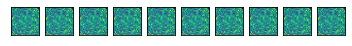

<Figure size 72x720 with 0 Axes>

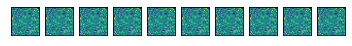

<Figure size 72x720 with 0 Axes>

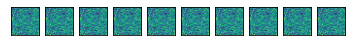

<Figure size 72x720 with 0 Axes>

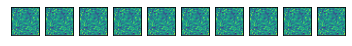

<Figure size 72x720 with 0 Axes>

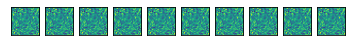

<Figure size 72x720 with 0 Axes>

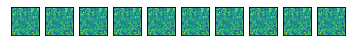

<Figure size 72x720 with 0 Axes>

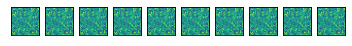

<Figure size 72x720 with 0 Axes>

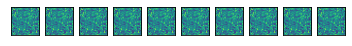

<Figure size 72x720 with 0 Axes>

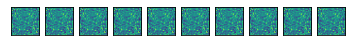

<Figure size 72x720 with 0 Axes>

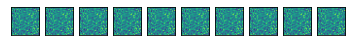

<Figure size 72x720 with 0 Axes>

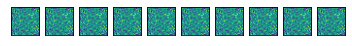

<Figure size 72x720 with 0 Axes>

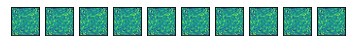

<Figure size 72x720 with 0 Axes>

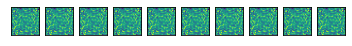

<Figure size 72x720 with 0 Axes>

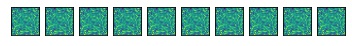

<Figure size 72x720 with 0 Axes>

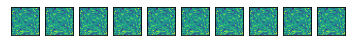

<Figure size 72x720 with 0 Axes>

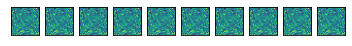

<Figure size 72x720 with 0 Axes>

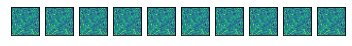

<Figure size 72x720 with 0 Axes>

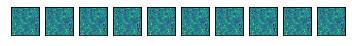

<Figure size 72x720 with 0 Axes>

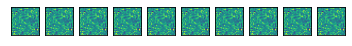

<Figure size 72x720 with 0 Axes>

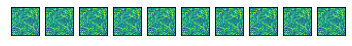

<Figure size 72x720 with 0 Axes>

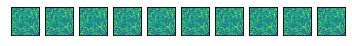

<Figure size 72x720 with 0 Axes>

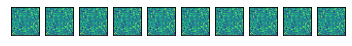

<Figure size 72x720 with 0 Axes>

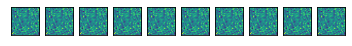

<Figure size 72x720 with 0 Axes>

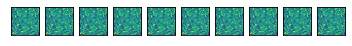

<Figure size 72x720 with 0 Axes>

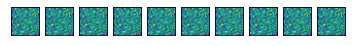

<Figure size 72x720 with 0 Axes>

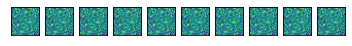

<Figure size 72x720 with 0 Axes>

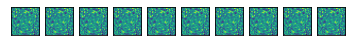

<Figure size 72x720 with 0 Axes>

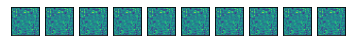

<Figure size 72x720 with 0 Axes>

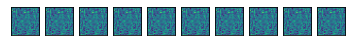

<Figure size 72x720 with 0 Axes>

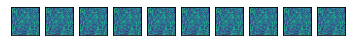

<Figure size 72x720 with 0 Axes>

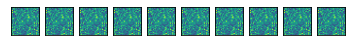

<Figure size 72x720 with 0 Axes>

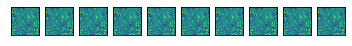

<Figure size 72x720 with 0 Axes>

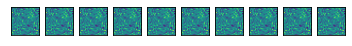

<Figure size 72x720 with 0 Axes>

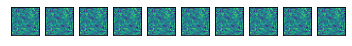

<Figure size 72x720 with 0 Axes>

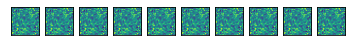

<Figure size 72x720 with 0 Axes>

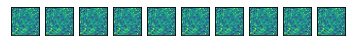

<Figure size 72x720 with 0 Axes>

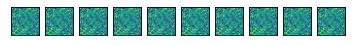

<Figure size 72x720 with 0 Axes>

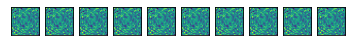

<Figure size 72x720 with 0 Axes>

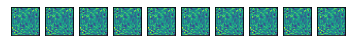

<Figure size 72x720 with 0 Axes>

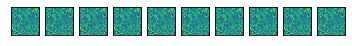

<Figure size 72x720 with 0 Axes>

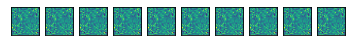

Epoch: [ 1] [ 100/ 468] D_loss: 0.40428323, G_loss: 0.18958701


<Figure size 72x720 with 0 Axes>

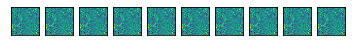

<Figure size 72x720 with 0 Axes>

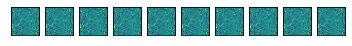

<Figure size 72x720 with 0 Axes>

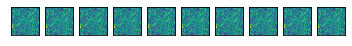

<Figure size 72x720 with 0 Axes>

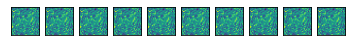

<Figure size 72x720 with 0 Axes>

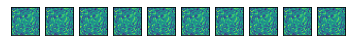

<Figure size 72x720 with 0 Axes>

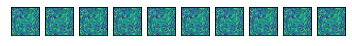

<Figure size 72x720 with 0 Axes>

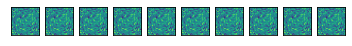

<Figure size 72x720 with 0 Axes>

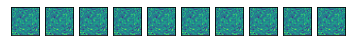

<Figure size 72x720 with 0 Axes>

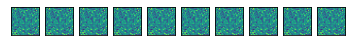

<Figure size 72x720 with 0 Axes>

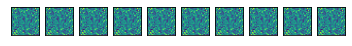

<Figure size 72x720 with 0 Axes>

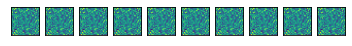

<Figure size 72x720 with 0 Axes>

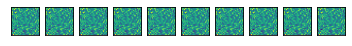

<Figure size 72x720 with 0 Axes>

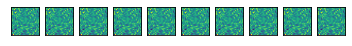

<Figure size 72x720 with 0 Axes>

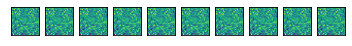

<Figure size 72x720 with 0 Axes>

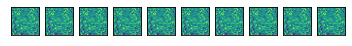

<Figure size 72x720 with 0 Axes>

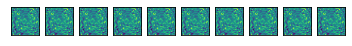

<Figure size 72x720 with 0 Axes>

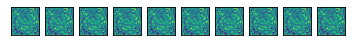

<Figure size 72x720 with 0 Axes>

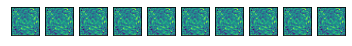

<Figure size 72x720 with 0 Axes>

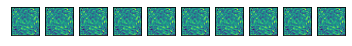

<Figure size 72x720 with 0 Axes>

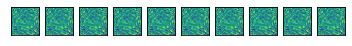

<Figure size 72x720 with 0 Axes>

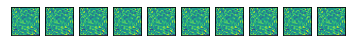

<Figure size 72x720 with 0 Axes>

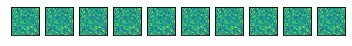

<Figure size 72x720 with 0 Axes>

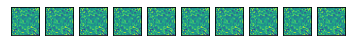

<Figure size 72x720 with 0 Axes>

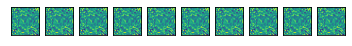

<Figure size 72x720 with 0 Axes>

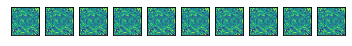

<Figure size 72x720 with 0 Axes>

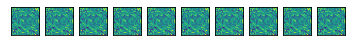

<Figure size 72x720 with 0 Axes>

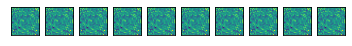

<Figure size 72x720 with 0 Axes>

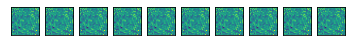

<Figure size 72x720 with 0 Axes>

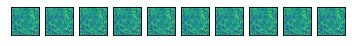

<Figure size 72x720 with 0 Axes>

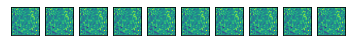

<Figure size 72x720 with 0 Axes>

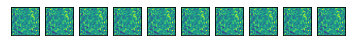

<Figure size 72x720 with 0 Axes>

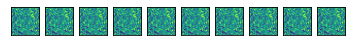

<Figure size 72x720 with 0 Axes>

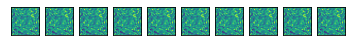

<Figure size 72x720 with 0 Axes>

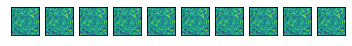

<Figure size 72x720 with 0 Axes>

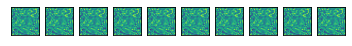

<Figure size 72x720 with 0 Axes>

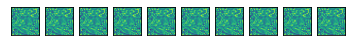

<Figure size 72x720 with 0 Axes>

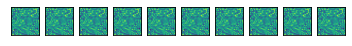

<Figure size 72x720 with 0 Axes>

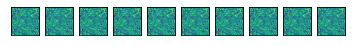

<Figure size 72x720 with 0 Axes>

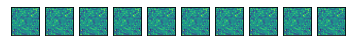

<Figure size 72x720 with 0 Axes>

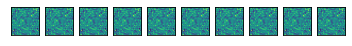

<Figure size 72x720 with 0 Axes>

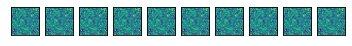

<Figure size 72x720 with 0 Axes>

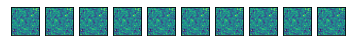

<Figure size 72x720 with 0 Axes>

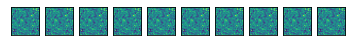

<Figure size 72x720 with 0 Axes>

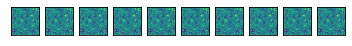

<Figure size 72x720 with 0 Axes>

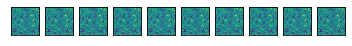

<Figure size 72x720 with 0 Axes>

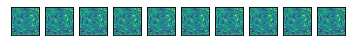

<Figure size 72x720 with 0 Axes>

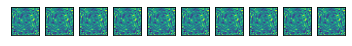

<Figure size 72x720 with 0 Axes>

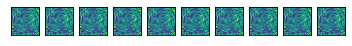

<Figure size 72x720 with 0 Axes>

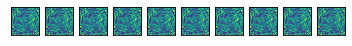

<Figure size 72x720 with 0 Axes>

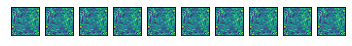

Epoch: [ 1] [ 150/ 468] D_loss: 0.40223682, G_loss: 0.20421809


<Figure size 72x720 with 0 Axes>

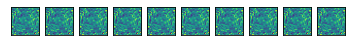

<Figure size 72x720 with 0 Axes>

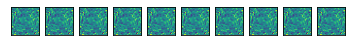

<Figure size 72x720 with 0 Axes>

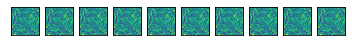

<Figure size 72x720 with 0 Axes>

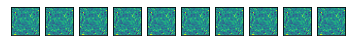

<Figure size 72x720 with 0 Axes>

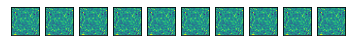

<Figure size 72x720 with 0 Axes>

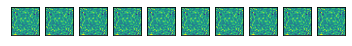

<Figure size 72x720 with 0 Axes>

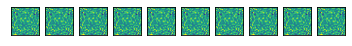

<Figure size 72x720 with 0 Axes>

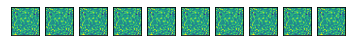

<Figure size 72x720 with 0 Axes>

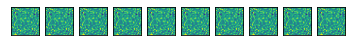

<Figure size 72x720 with 0 Axes>

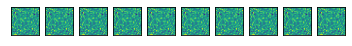

<Figure size 72x720 with 0 Axes>

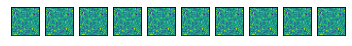

<Figure size 72x720 with 0 Axes>

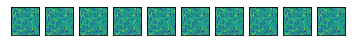

<Figure size 72x720 with 0 Axes>

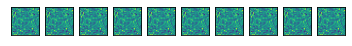

<Figure size 72x720 with 0 Axes>

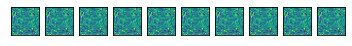

<Figure size 72x720 with 0 Axes>

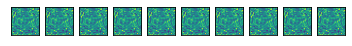

<Figure size 72x720 with 0 Axes>

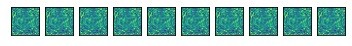

<Figure size 72x720 with 0 Axes>

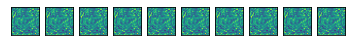

<Figure size 72x720 with 0 Axes>

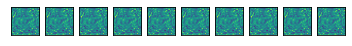

<Figure size 72x720 with 0 Axes>

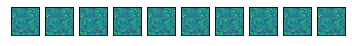

<Figure size 72x720 with 0 Axes>

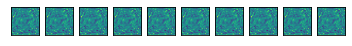

<Figure size 72x720 with 0 Axes>

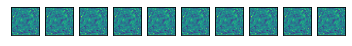

<Figure size 72x720 with 0 Axes>

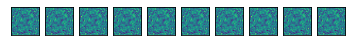

<Figure size 72x720 with 0 Axes>

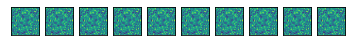

<Figure size 72x720 with 0 Axes>

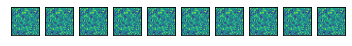

<Figure size 72x720 with 0 Axes>

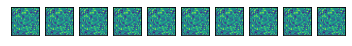

<Figure size 72x720 with 0 Axes>

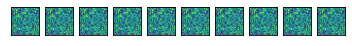

<Figure size 72x720 with 0 Axes>

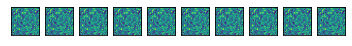

<Figure size 72x720 with 0 Axes>

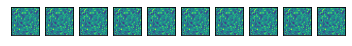

<Figure size 72x720 with 0 Axes>

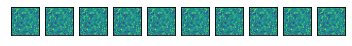

<Figure size 72x720 with 0 Axes>

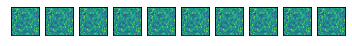

<Figure size 72x720 with 0 Axes>

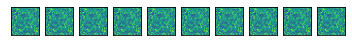

<Figure size 72x720 with 0 Axes>

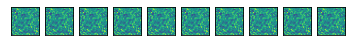

<Figure size 72x720 with 0 Axes>

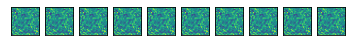

<Figure size 72x720 with 0 Axes>

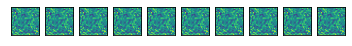

<Figure size 72x720 with 0 Axes>

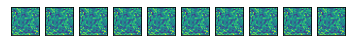

<Figure size 72x720 with 0 Axes>

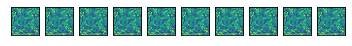

<Figure size 72x720 with 0 Axes>

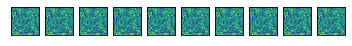

<Figure size 72x720 with 0 Axes>

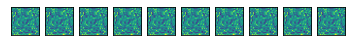

<Figure size 72x720 with 0 Axes>

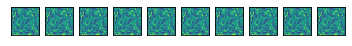

<Figure size 72x720 with 0 Axes>

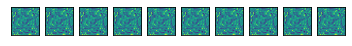

<Figure size 72x720 with 0 Axes>

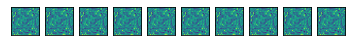

<Figure size 72x720 with 0 Axes>

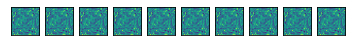

<Figure size 72x720 with 0 Axes>

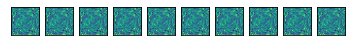

<Figure size 72x720 with 0 Axes>

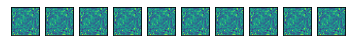

<Figure size 72x720 with 0 Axes>

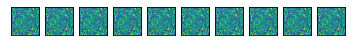

<Figure size 72x720 with 0 Axes>

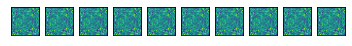

<Figure size 72x720 with 0 Axes>

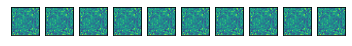

<Figure size 72x720 with 0 Axes>

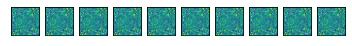

<Figure size 72x720 with 0 Axes>

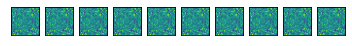

<Figure size 72x720 with 0 Axes>

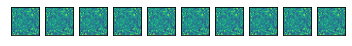

Epoch: [ 1] [ 200/ 468] D_loss: 0.40591985, G_loss: 0.19845995


<Figure size 72x720 with 0 Axes>

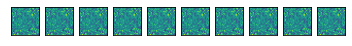

<Figure size 72x720 with 0 Axes>

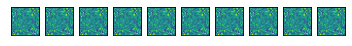

<Figure size 72x720 with 0 Axes>

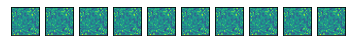

<Figure size 72x720 with 0 Axes>

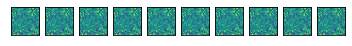

<Figure size 72x720 with 0 Axes>

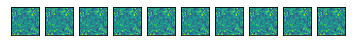

<Figure size 72x720 with 0 Axes>

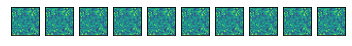

<Figure size 72x720 with 0 Axes>

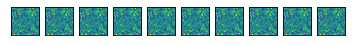

<Figure size 72x720 with 0 Axes>

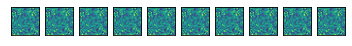

<Figure size 72x720 with 0 Axes>

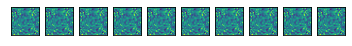

<Figure size 72x720 with 0 Axes>

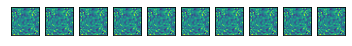

<Figure size 72x720 with 0 Axes>

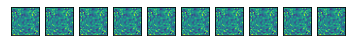

<Figure size 72x720 with 0 Axes>

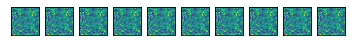

<Figure size 72x720 with 0 Axes>

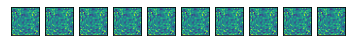

<Figure size 72x720 with 0 Axes>

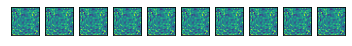

<Figure size 72x720 with 0 Axes>

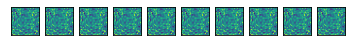

<Figure size 72x720 with 0 Axes>

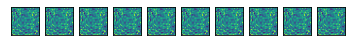

<Figure size 72x720 with 0 Axes>

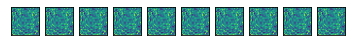

<Figure size 72x720 with 0 Axes>

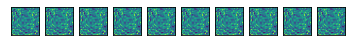

<Figure size 72x720 with 0 Axes>

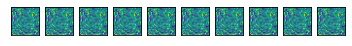

<Figure size 72x720 with 0 Axes>

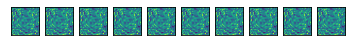

<Figure size 72x720 with 0 Axes>

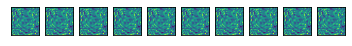

<Figure size 72x720 with 0 Axes>

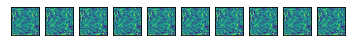

<Figure size 72x720 with 0 Axes>

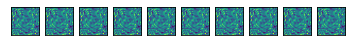

<Figure size 72x720 with 0 Axes>

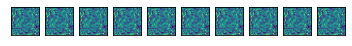

<Figure size 72x720 with 0 Axes>

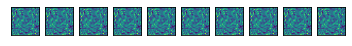

<Figure size 72x720 with 0 Axes>

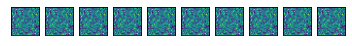

<Figure size 72x720 with 0 Axes>

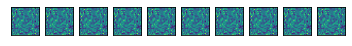

<Figure size 72x720 with 0 Axes>

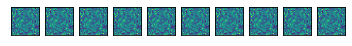

<Figure size 72x720 with 0 Axes>

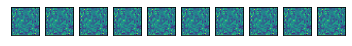

<Figure size 72x720 with 0 Axes>

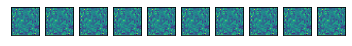

<Figure size 72x720 with 0 Axes>

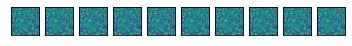

<Figure size 72x720 with 0 Axes>

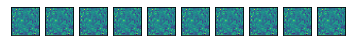

<Figure size 72x720 with 0 Axes>

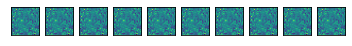

<Figure size 72x720 with 0 Axes>

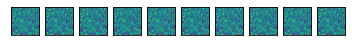

<Figure size 72x720 with 0 Axes>

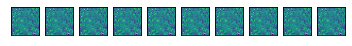

<Figure size 72x720 with 0 Axes>

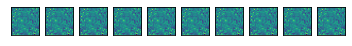

<Figure size 72x720 with 0 Axes>

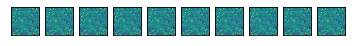

<Figure size 72x720 with 0 Axes>

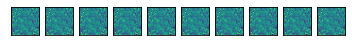

<Figure size 72x720 with 0 Axes>

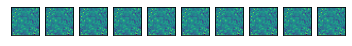

<Figure size 72x720 with 0 Axes>

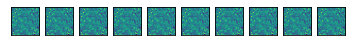

<Figure size 72x720 with 0 Axes>

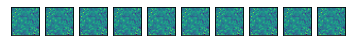

<Figure size 72x720 with 0 Axes>

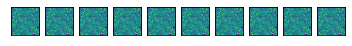

<Figure size 72x720 with 0 Axes>

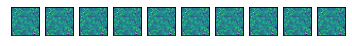

<Figure size 72x720 with 0 Axes>

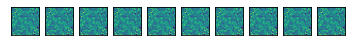

<Figure size 72x720 with 0 Axes>

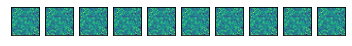

<Figure size 72x720 with 0 Axes>

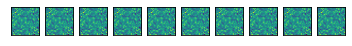

<Figure size 72x720 with 0 Axes>

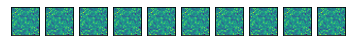

<Figure size 72x720 with 0 Axes>

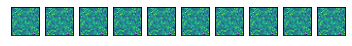

<Figure size 72x720 with 0 Axes>

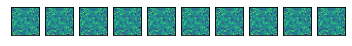

<Figure size 72x720 with 0 Axes>

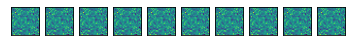

Epoch: [ 1] [ 250/ 468] D_loss: 0.40480459, G_loss: 0.20211264


<Figure size 72x720 with 0 Axes>

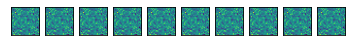

<Figure size 72x720 with 0 Axes>

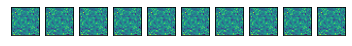

<Figure size 72x720 with 0 Axes>

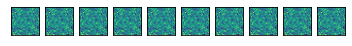

<Figure size 72x720 with 0 Axes>

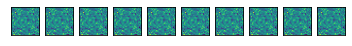

<Figure size 72x720 with 0 Axes>

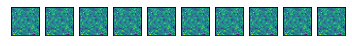

<Figure size 72x720 with 0 Axes>

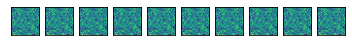

<Figure size 72x720 with 0 Axes>

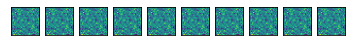

<Figure size 72x720 with 0 Axes>

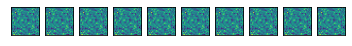

<Figure size 72x720 with 0 Axes>

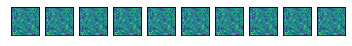

<Figure size 72x720 with 0 Axes>

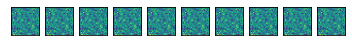

<Figure size 72x720 with 0 Axes>

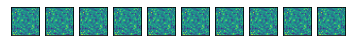

<Figure size 72x720 with 0 Axes>

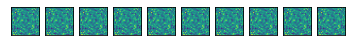

<Figure size 72x720 with 0 Axes>

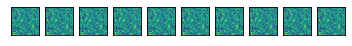

<Figure size 72x720 with 0 Axes>

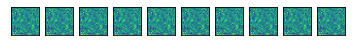

<Figure size 72x720 with 0 Axes>

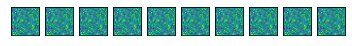

<Figure size 72x720 with 0 Axes>

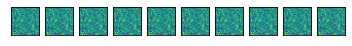

<Figure size 72x720 with 0 Axes>

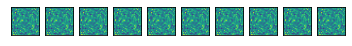

<Figure size 72x720 with 0 Axes>

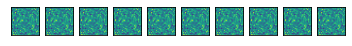

<Figure size 72x720 with 0 Axes>

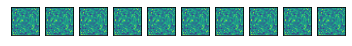

<Figure size 72x720 with 0 Axes>

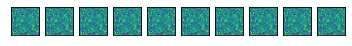

<Figure size 72x720 with 0 Axes>

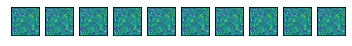

<Figure size 72x720 with 0 Axes>

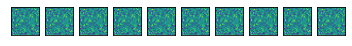

<Figure size 72x720 with 0 Axes>

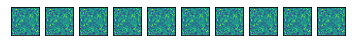

<Figure size 72x720 with 0 Axes>

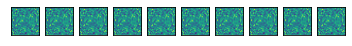

<Figure size 72x720 with 0 Axes>

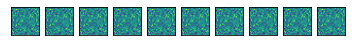

<Figure size 72x720 with 0 Axes>

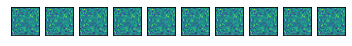

<Figure size 72x720 with 0 Axes>

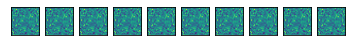

<Figure size 72x720 with 0 Axes>

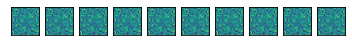

<Figure size 72x720 with 0 Axes>

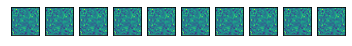

<Figure size 72x720 with 0 Axes>

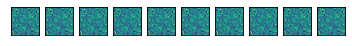

<Figure size 72x720 with 0 Axes>

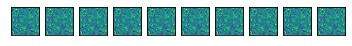

<Figure size 72x720 with 0 Axes>

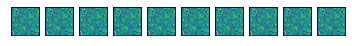

<Figure size 72x720 with 0 Axes>

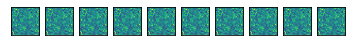

<Figure size 72x720 with 0 Axes>

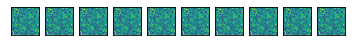

<Figure size 72x720 with 0 Axes>

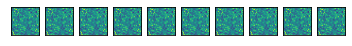

<Figure size 72x720 with 0 Axes>

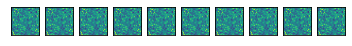

<Figure size 72x720 with 0 Axes>

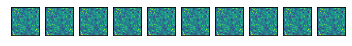

<Figure size 72x720 with 0 Axes>

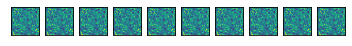

<Figure size 72x720 with 0 Axes>

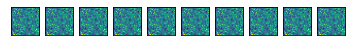

<Figure size 72x720 with 0 Axes>

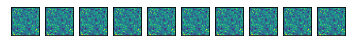

<Figure size 72x720 with 0 Axes>

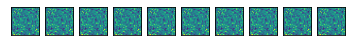

<Figure size 72x720 with 0 Axes>

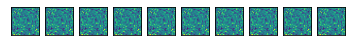

<Figure size 72x720 with 0 Axes>

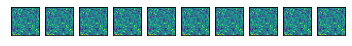

<Figure size 72x720 with 0 Axes>

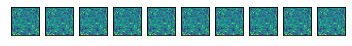

<Figure size 72x720 with 0 Axes>

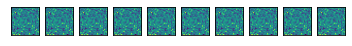

<Figure size 72x720 with 0 Axes>

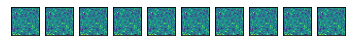

<Figure size 72x720 with 0 Axes>

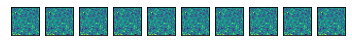

<Figure size 72x720 with 0 Axes>

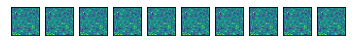

<Figure size 72x720 with 0 Axes>

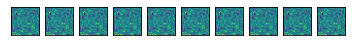

<Figure size 72x720 with 0 Axes>

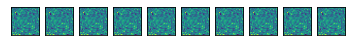

Epoch: [ 1] [ 300/ 468] D_loss: 0.40367252, G_loss: 0.20671025


<Figure size 72x720 with 0 Axes>

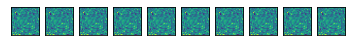

<Figure size 72x720 with 0 Axes>

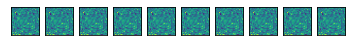

<Figure size 72x720 with 0 Axes>

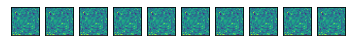

<Figure size 72x720 with 0 Axes>

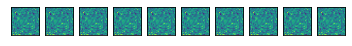

<Figure size 72x720 with 0 Axes>

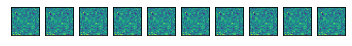

<Figure size 72x720 with 0 Axes>

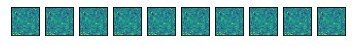

<Figure size 72x720 with 0 Axes>

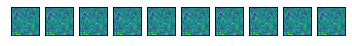

<Figure size 72x720 with 0 Axes>

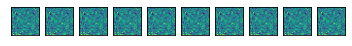

<Figure size 72x720 with 0 Axes>

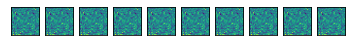

<Figure size 72x720 with 0 Axes>

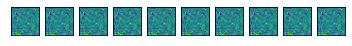

<Figure size 72x720 with 0 Axes>

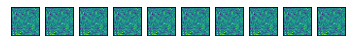

<Figure size 72x720 with 0 Axes>

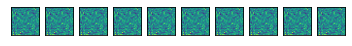

<Figure size 72x720 with 0 Axes>

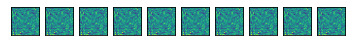

<Figure size 72x720 with 0 Axes>

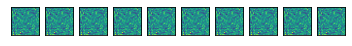

<Figure size 72x720 with 0 Axes>

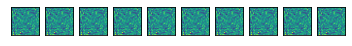

<Figure size 72x720 with 0 Axes>

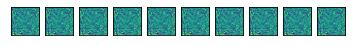

<Figure size 72x720 with 0 Axes>

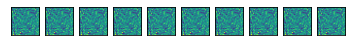

<Figure size 72x720 with 0 Axes>

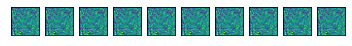

<Figure size 72x720 with 0 Axes>

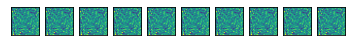

KeyboardInterrupt: ignored

<Figure size 72x720 with 0 Axes>

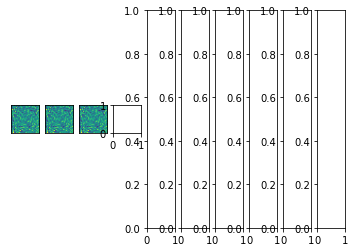

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params = {'beta1': 0.05, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':30}
params['z_dim'] =2
params['base_size'] = 128

gan = GAN(params)



gan.train()

